## Dependecies


In [2]:
import sys
from pathlib import Path
from torchvision import datasets

In [2]:
import sys
sys.path.append("D:/Unlearning")

In [3]:
sys.path

['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\python310.zip',
 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\DLLs',
 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\lib',
 'C:\\Users\\izam1\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0',
 'd:\\Unlearning\\venv',
 '',
 'd:\\Unlearning\\venv\\lib\\site-packages',
 'D:/Unlearning']

## Utils


In [3]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

data_root = project_root / "data"
data_root.mkdir(parents=True, exist_ok=True)


# DELETE IF GOING FOR LOCAL SETUP, ADD AHFQ DATASET TO "./data" FOLDER


In [5]:
data_root

WindowsPath('D:/Unlearning/data')

In [4]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed

set_seed()

# Prepare Dataloaders
from methods.naive.naive_utils import init_dataloaders

# Train loop
from utils.train_test_metrics import train_model

# Plot losses
from utils.train_test_metrics import plot_training_history

# Test function
from utils.train_test_metrics import test_model

# Merics
from utils.train_test_metrics import show_metrics

# Init model
from models.effnetb0 import init_model_effnetb0

Device used: cuda


## Parameters (arbitrary chosen)


In [9]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 3

# Simple base training


## Init model


In [8]:
model, model_name, criterion, optimizer, transform = init_model_effnetb0(
    learning_rate=LEARNING_RATE, fc_output=3
)

Init model...
Done initializing model.
Model ID: 2212145856320, Optimizer ID: 2212146324448, Criterion ID: 2212146321664


## Init dataloaders


In [9]:
train_dataset = datasets.ImageFolder(root=data_root / "afhq/train", transform=transform)
test_dataset = datasets.ImageFolder(root=data_root / "afhq/val", transform=transform)
data_split_path = "afhq_data_splits.json"

train_loader, val_loader, test_loader, classes = init_dataloaders(
    datasets=(train_dataset, test_dataset),
    val_ratio=0.2,
    batch_size=BATCH_SIZE,
    info_file_path=data_split_path,
)

Prepare DataLoaders...
Done preparing DataLoaders.


## Call train


In [ ]:
import time

start_time = time.perf_counter()
train_model(
    model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS
)
end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

## Plot history losses


In [5]:
results_path = Path("D:/Unlearning/results/animal_faces/naive")

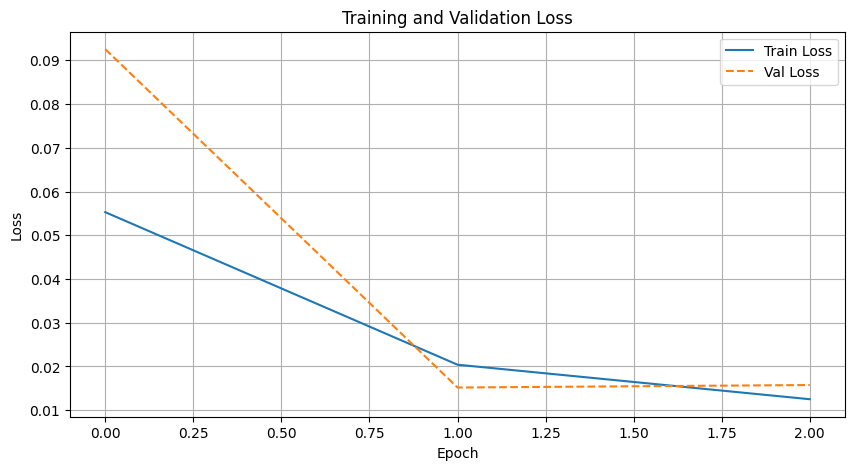

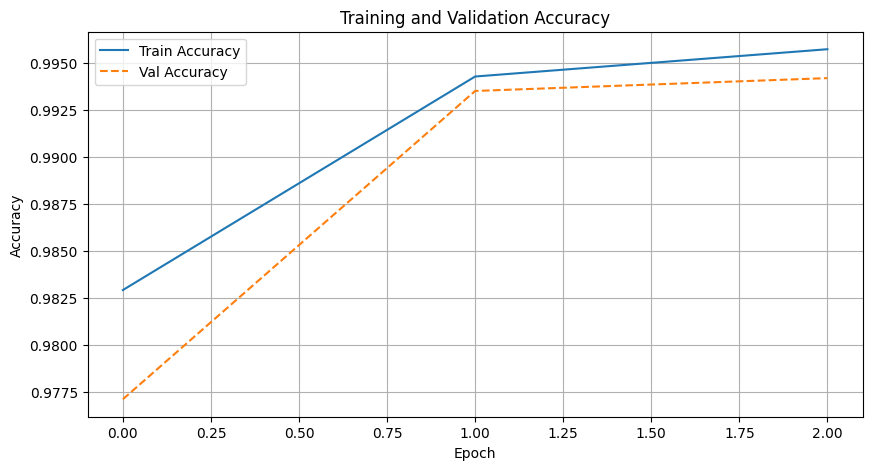

In [12]:
history_path = results_path / f"{model_name}_history.json"
plot_training_history(history_path)

## Call test


In [ ]:
model_path = results_path / f"{model_name}_model.pth"
test_model(model, model_name, model_path, test_loader, results_path)

Loading and testing model: EffNetB0_AFHQ


Evaluating model: D:\Unlearning\results\animal_faces\naive\EffNetB0_AFHQ_model.pth: 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]

Predictions and labels saved to EffNetB0_AFHQ_predictions.json


## Show metrics


Metrics for EffNetB0_AFHQ:
  - Test Accuracy: 0.9980
  - Precision: 0.9980
  - Recall: 0.9980
  - F1 Score: 0.9980


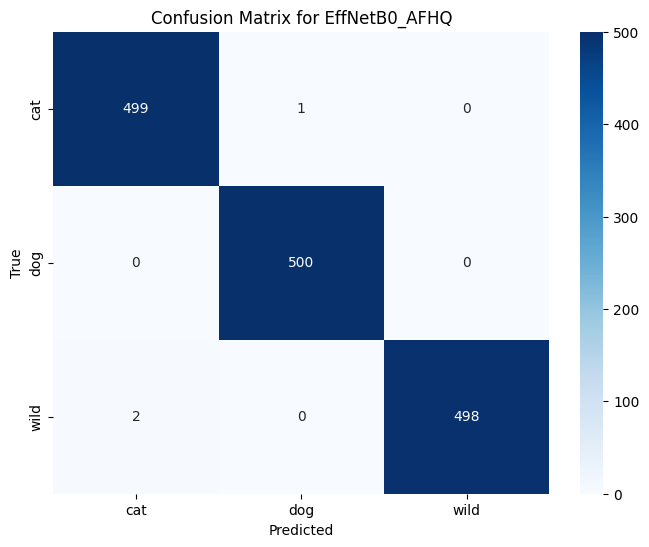

In [19]:
predictions_path = results_path / f"{model_name}_predictions.json"
# classes = ['cat', 'dog', 'wildlife']
show_metrics(predictions_path, classes, model_name)

## Utils naive


In [6]:
# Select samples to unlearn (10% random)
from utils.utils import select_samples_to_unlearn

# Update data splits
from methods.naive.naive_utils import update_splits_after_unlearning

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# Naive unlearning


### Init new model


In [7]:
data_splits_file = results_path / "afhq_data_splits.json"
unlearn_samples_file = results_path / "afhq_samples_to_unlearn_30per.json"
updated_data_splits_path = results_path / "updated_afhq_data_splits.json"

In [10]:
model, model_name, criterion, optimizer, transform = init_model_effnetb0(
    learning_rate=LEARNING_RATE, fc_output=3
)
model_name = "naive_unlearning_" + model_name

Init model...
Done initializing model.
Model ID: 2998605293760, Optimizer ID: 2997920440304, Criterion ID: 2997920441504


### Init data


In [11]:
train_dataset = datasets.ImageFolder(root=data_root / "afhq/train", transform=transform)
test_dataset = datasets.ImageFolder(root=data_root / "afhq/val", transform=transform)

## Select samples to unlearn


In [12]:
# ONLY ONCE
select_samples_to_unlearn(data_splits_file, unlearn_samples_file, unlearn_ratio=0.3, results_path=results_path)

Unlearn indices saved to D:\Unlearning\results\animal_faces\naive\afhq_samples_to_unlearn_30per.json


## Update data splits -> delete samples


In [13]:
update_splits_after_unlearning(
    data_splits_file, unlearn_samples_file, updated_data_splits_path
)

Updated splits saved to D:\Unlearning\results\animal_faces\naive\updated_afhq_data_splits.json


## Recreate DataLoaders from json files


In [14]:
train_loader, val_loader, test_loader, classes = recreate_dataloaders(
    data_splits_file=updated_data_splits_path,
    datasets=(train_dataset, test_dataset),
    batch_size=BATCH_SIZE,
)

Recreating DataLoaders...
Done recreating DataLoaders.


## Re-train


In [ ]:
import time

start_time = time.perf_counter()
train_model(
    model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS
)
end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

## Plot history losses


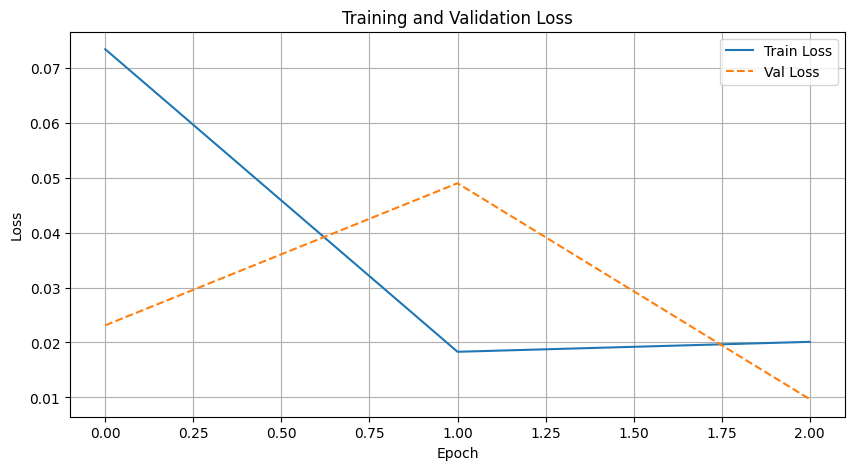

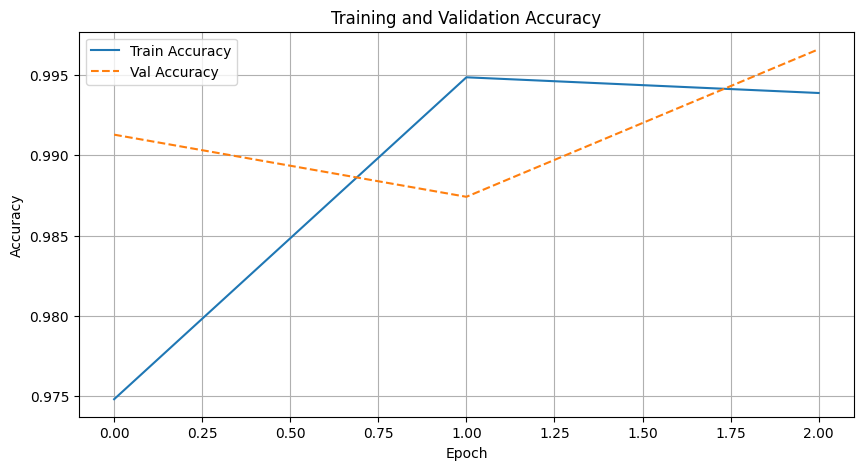

In [15]:
history_path = results_path / f"{model_name}_history.json"
plot_training_history(history_path)

## Re-test


In [17]:
model_path = results_path / f"{model_name}_model.pth"
test_model(model, model_name, model_path, test_loader, results_path=results_path)

Loading and testing model: naive_unlearning_EffNetB0_AFHQ


Evaluating model: D:\Unlearning\results\animal_faces\naive\naive_unlearning_EffNetB0_AFHQ_model.pth: 100%|██████████| 24/24 [00:09<00:00,  2.51it/s]

Predictions and labels saved to naive_unlearning_EffNetB0_AFHQ_predictions.json


## Show metrics


Metrics for naive_unlearning_EffNetB0_AFHQ:
  - Test Accuracy: 0.9960
  - Precision: 0.9960
  - Recall: 0.9960
  - F1 Score: 0.9960


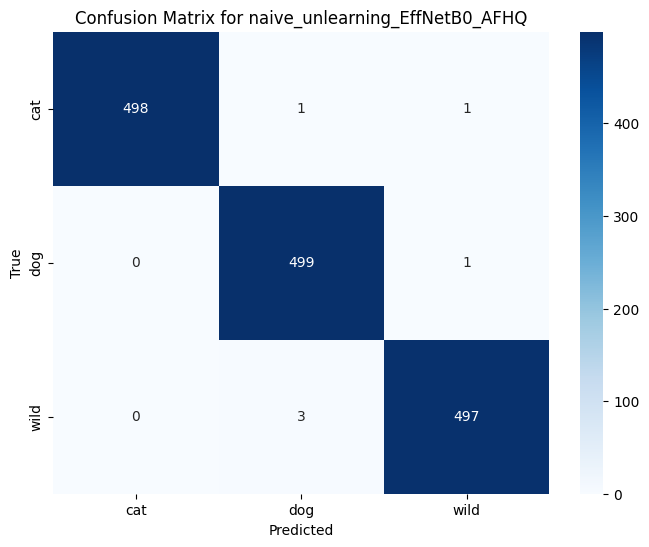

In [18]:
predictions_path = results_path / f"{model_name}_predictions.json"
# classes = ['cat', 'dog', 'wildlife']
show_metrics(predictions_path, classes, model_name)